In [36]:
import torch
import torch.nn as nn 
from torchvision import  datasets, models, transforms 
from torch.utils.data import DataLoader, WeightedRandomSampler
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image
import time
import os 
from collections import Counter
import torch.optim as optim
from torchvision.models import DenseNet121_Weights
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize


In [19]:
transform = transforms.Compose([
    
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #* imageNet stander 
])

In [20]:
data_dir = './Datasets/LungXRays-grayscale'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)
print(f'training data: {len(train_dataset)}')
print(f'validation data: {len(val_dataset)}')
print(f'test data: {len(test_dataset)}')

 


training data: 4861
validation data: 1620
test data: 1625


In [21]:
#TODO  check for the distribuation classes
def get_class_distribution(dataset): 
    counter_pr_class = Counter([dataset.classes[label] for _, label in dataset.imgs])
    return counter_pr_class   
train_distribution = get_class_distribution(train_dataset)
print(train_distribution)


Counter({'COVID19': 1218, 'Pneumonia': 1218, 'Tuberculosis': 1218, 'Normal': 1207})


In [22]:
##* datasets loader

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True); 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

dataiter = iter(train_loader)
imgs, labels = next(dataiter)
print(imgs.shape)
print(torch.min(imgs), torch.max(imgs))
print(f'images shapes: {imgs.shape}')

torch.Size([32, 3, 224, 224])
tensor(-2.1179) tensor(2.6400)
images shapes: torch.Size([32, 3, 224, 224])


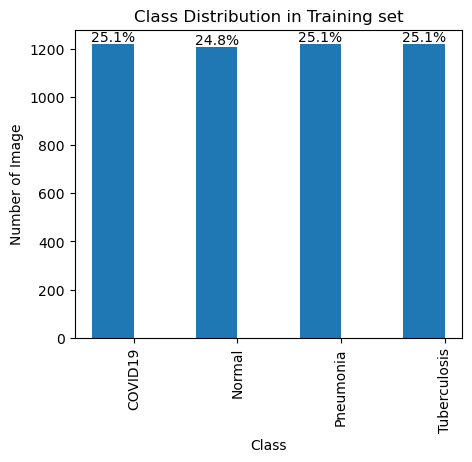

In [23]:
def plot_combined_distributions(original_dist,  dataset_name='Training Set'): 
    
    classes = list(original_dist.keys())
    original_counts = [original_dist[cls] for cls in classes]
    total_count = sum(original_counts)
 
    
    x = range(len(classes))
    width = 0.4 
    
    plt.figure(figsize=(5, 4))
    bars = plt.bar(x, original_counts, width=width, label = 'Original', align='center')
    #plt.bar([p + width for p in x], sample_counts, width=width, label ='weighted sampled', align='center')
    
    
    for bar, count in zip(bars, original_counts): 
        percent = (count / total_count) * 100
        plt.text(
            bar.get_x() + bar.get_width()/2, 
            bar.get_height(), 
            f'{percent:.1f}%', 
            ha= 'center', 
            va=  'bottom'
        )
        

    plt.xlabel('Class')
    plt.ylabel('Number of Image')
    plt.title('Class Distribution in Training set')

    plt.xticks([p+width / 2 for p in x], classes, rotation = 90)
   
    plt.show()

plot_combined_distributions(train_distribution )




In [24]:
#pred trained model DenseNet121 
num_classes = len(train_dataset.classes)
densenet121_model = models.densenet121(weights=DenseNet121_Weights.DEFAULT)
#making modification of the number of class
densenet121_model.classifier = nn.Linear(densenet121_model.classifier.in_features, num_classes)


In [25]:
#Hyperparamaters 
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = densenet121_model.to(device) 
criterion = nn.CrossEntropyLoss();  
optimizer = optim.Adam(model.parameters(), lr=0.00001 )
#optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
num_epoch = 20

In [26]:
#* we need to train the module 

def train_model(model, train_loader, criterion, optimizer, device):
    

        #* we sting the model into train mode
    model.train(); 
    
    learning_loss = 0.0; 
    correct = 0; 
    total = 0; 
    
    for inputs, labels in train_loader: 
        
        inputs, labels = inputs.to(device), labels.to(device)
        #* starting with the gradient from  the intial point 0 
        optimizer.zero_grad()
        outputs = model(inputs); 
        loss = criterion(outputs, labels); 
        loss.backward();
        optimizer.step(); 
        learning_loss += loss.item(); 
        _, predict = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predict == labels).sum().item(); 
    
    learning_loss_result = learning_loss / total if total > 0 else 0
    train_acc = 100 * correct /total if total > 0 else 0
    return learning_loss_result, train_acc
                

In [27]:
### evaluation the model

def validation(model, val_loader, criterion, device ): 
    model.eval(); 
    running_loss = 0.0; 
    total = 0; 
    correct = 0; 
    
    with torch.no_grad(): 
        for inputs, labels in val_loader: 
            inputs, labels = inputs.to(device), labels.to(device); 
            outputs = model(inputs); 
            loss = criterion(outputs, labels); 
            running_loss += loss.item(); 
            _,predict = torch.max(outputs, 1); 
            
            total  += labels.size(0); 
            correct  += (predict == labels).sum().item()
            
    result_running_loss = running_loss / total if total > 0 else 0 
    result_val_acc = 100* correct / total if total > 0 else 0; 
    return  result_running_loss, result_val_acc; 

In [28]:
#* class for the early stopping 
class EarlyStopping:
    def __init__(self, patience =5, delta = 0, path='best.pt'):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta
        self.path = path
    
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.delta:
            
            #* here we keep track for if val decreases and save the best model
            print(f'Validation loss started decreasing from: {self.best_loss:.4f} to {val_loss:.4f} saves best model..')
            self.best_loss = val_loss 
            self.Save_best_model(model)
            self.counter = 0
        else: 
            self.counter += 1 
            print(f'Early stopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
    
    def Save_best_model(self, model): 
        torch.save(model.state_dict(), self.path)
            
         
        
         

In [29]:
earlyStopping = EarlyStopping(patience=5,  path='best_denseNet121.pth')
start_time = time.time()
train_losses, train_accs, val_losses, val_accs =[], [], [], []
for epoch in range(num_epoch):
    
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validation(model, val_loader, criterion, device)
    train_losses.append(train_loss); 
    train_accs.append(train_acc); 
    val_losses.append(val_loss)
    val_accs.append(val_acc); 
    

    print(f'Epoch {epoch+1}/{num_epoch}: Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    earlyStopping(val_loss, model)
    if earlyStopping.early_stop: 
        print('Note early stopping is triggered no need more training')
        break
end_time = time.time()
print(f'Training Time for DenseNet121: {end_time - start_time:.2f} seconds')

Epoch 1/20: Train Loss: 0.0260 Train Acc: 73.3800, Val Loss: 0.0145, Val Acc: 89.5062
Validation loss started decreasing from: inf to 0.0145 saves best model..
Epoch 2/20: Train Loss: 0.0114 Train Acc: 90.3929, Val Loss: 0.0083, Val Acc: 92.7778
Validation loss started decreasing from: 0.0145 to 0.0083 saves best model..
Epoch 3/20: Train Loss: 0.0073 Train Acc: 93.4787, Val Loss: 0.0059, Val Acc: 94.8765
Validation loss started decreasing from: 0.0083 to 0.0059 saves best model..
Epoch 4/20: Train Loss: 0.0055 Train Acc: 95.1450, Val Loss: 0.0048, Val Acc: 95.3086
Validation loss started decreasing from: 0.0059 to 0.0048 saves best model..
Epoch 5/20: Train Loss: 0.0045 Train Acc: 95.9268, Val Loss: 0.0041, Val Acc: 95.8642
Validation loss started decreasing from: 0.0048 to 0.0041 saves best model..
Epoch 6/20: Train Loss: 0.0038 Train Acc: 96.3999, Val Loss: 0.0036, Val Acc: 96.5432
Validation loss started decreasing from: 0.0041 to 0.0036 saves best model..
Epoch 7/20: Train Loss: 0

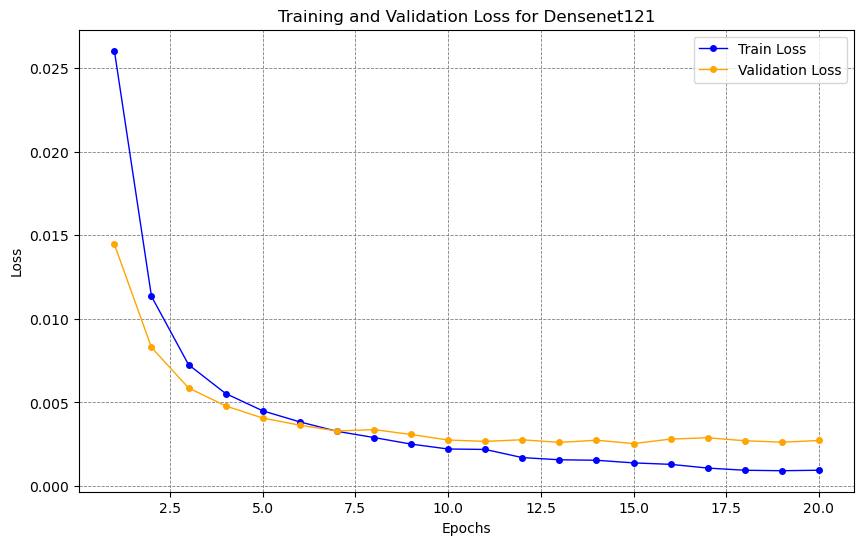

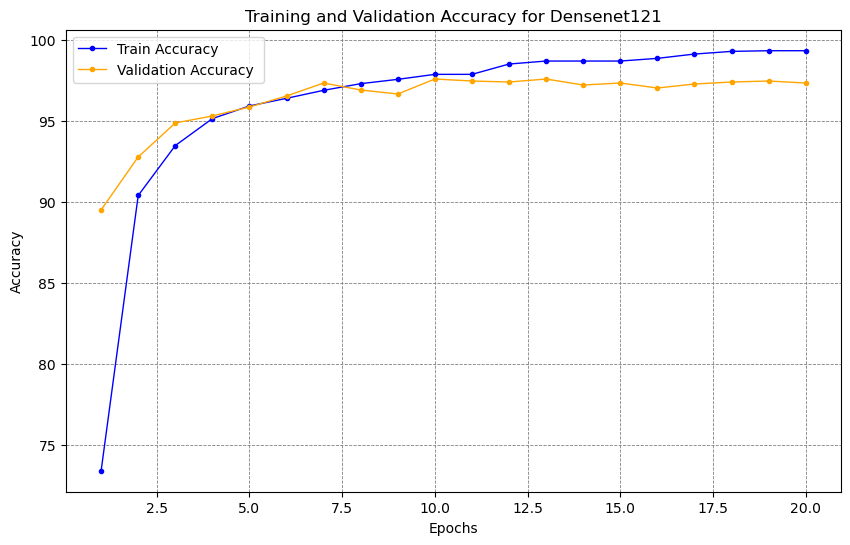

In [30]:
def Plot_metrics(train_losses, val_losses, train_accs, val_accs):
    #* range for the plot 
    epoch = range(1, len(train_losses)+1)
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_losses, label= 'Train Loss', color = 'blue',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.plot(epoch, val_losses, label='Validation Loss', color='orange',  marker='o', markersize=4, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss for Densenet121')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()
    
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(epoch, train_accs, label= 'Train Accuracy ', color = 'blue',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.plot(epoch, val_accs, label='Validation Accuracy ', color='orange',  marker='o', markersize=3, linestyle='-', linewidth=1)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy for Densenet121')
    plt.grid(True, which='both', linestyle='--', linewidth=0.6, color='gray')
    plt.show()



Plot_metrics(train_losses, val_losses, train_accs, val_accs)

In [31]:
densenet121_model.load_state_dict(torch.load('best_denseNet121.pth', map_location=device))
model = densenet121_model.to(device)


/var/folders/4g/tf_931w11w99w336_dt_g9740000gn/T/ipykernel_78596/2557672249.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  densenet121_model.load_state_dict(torch.load(

In [37]:
# evaluation 

#*  Model evaluation 
def evaluation(model, test_loader, criterion, device):
    test_loss = 0.0
    all_pred = []
    all_labels = []
    all_probs = []   
    correct = 0
    total = 0
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
       
            _, predicted = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            
            all_pred.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
  
    result_test_loss = test_loss / len(test_loader)
    result_test_acc = 100 * correct / total
    
     
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs) 
    num_classes = all_probs.shape[1]
    y_true = label_binarize(all_labels, classes=range(num_classes))
    auc = roc_auc_score(y_true, all_probs, multi_class='ovr', average='macro')
    
    
    return result_test_loss, result_test_acc, all_pred, all_labels, auc, all_probs

In [39]:
## testing accuracy 
test_loss, test_acc, all_preds, all_labels, auc, all_probs= evaluation(model, test_loader, criterion, device)
print(f'Test Accuaracy: {test_acc:.4f} AUC: {auc:.4f}')

Test Accuaracy: 98.6462 AUC: 0.9994


Accuracy: 0.9864615384615385

 classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       406
           1       0.98      0.97      0.97       407
           2       0.97      0.98      0.98       404
           3       1.00      1.00      1.00       408

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



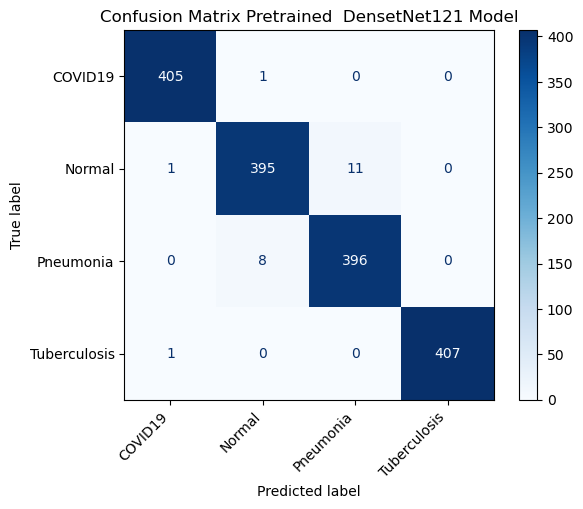

In [44]:
## Confusion metrics 
accuracy = accuracy_score(all_preds, all_labels)
print(f"Accuracy: {accuracy}")
print('\n classification Report')
cls_report = classification_report(all_preds, all_labels)
print(cls_report)

cm = confusion_matrix(all_preds, all_labels)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
display.plot(cmap='Blues')
plt.xticks(rotation = 45, ha= 'right')
plt.title('Confusion Matrix Pretrained  DensetNet121 Model')
plt.show()

In [48]:
#* for AUC plotting
#* plotting auc curve for each classes 

#* plotting auc curve for each classes 

def plot_roc_curve(all_labels, all_probs, num_classes, class_names):
    """
    Plot ROC curve for each class.
    Args:
        all_labels: Ground truth labels.
        all_probs: Predicted probabilities for each class.
        num_classes: Total number of classes.
        class_names: List of class names corresponding to the classes.
    """
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt
    
    y_true = label_binarize(all_labels, classes=range(num_classes))
    all_probs = np.array(all_probs)

    fpr = {}
    tpr = {}
    roc_auc = {}

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

 
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing (AUC = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-Class ROC Curve For DenseNet121')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()



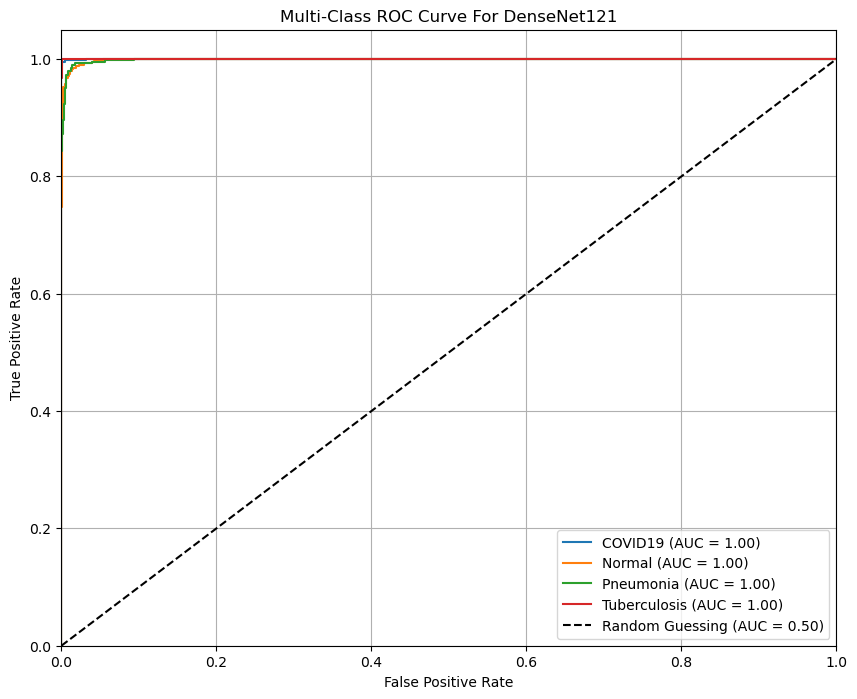

In [49]:
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes   
plot_roc_curve(all_labels, all_probs, num_classes, class_names)